In [1]:
import os

%load_ext autoreload
%autoreload 2

img_dir = "img/test_gpu_unet/"
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

In [2]:
"""
Check if we have a GPU

"""
import tensorflow as tf
tf.config.list_physical_devices()

2024-03-04 11:32:33.085763: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 11:32:33.085787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 11:32:33.086247: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-04 11:32:33.089455: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 11:32:34.932537: I exter

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
"""
Open and resize the images for training

"""

import pathlib
import warnings
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from cementum import processing, util

# We don't have the same number of images and masks, unfortunately
# So we'll just open this many
train_fraction = 0.8
n_imgs = 516
n_total = 516

# Choose some images and masks at random
gen = np.random.default_rng(0)
indices = gen.choice(np.arange(n_total), size=n_imgs, replace=False)

# Split into training and testing here
train_indices = gen.choice(indices, size=int(train_fraction * n_imgs), replace=False)
test_indices = np.array([i for i in indices if i not in train_indices])

data_dir = pathlib.Path("data/original cut/")
mask_dir = pathlib.Path("data/masks cut/")

img_paths = np.array(sorted(tuple(data_dir.glob(r"????.tif"))))
mask_paths = np.array(sorted(tuple(pathlib.Path(mask_dir).glob(r"????.tif"))))

img_size = (320, 320)
train_images = np.array(
    [
        processing.resize(Image.open(str(path)), img_size)
        for path in img_paths[train_indices]
    ]
)
test_images = np.array(
    [
        processing.resize(Image.open(str(path)), img_size)
        for path in img_paths[test_indices]
    ]
)

# Subtract 1 from masks to make them 0-indexed
train_masks = np.array(
    [
        processing.resize(Image.open(str(path)), img_size) - 1
        for path in mask_paths[train_indices]
    ]
)
test_masks = np.array(
    [
        processing.resize(Image.open(str(path)), img_size) - 1
        for path in mask_paths[test_indices]
    ]
)

# Check that the masks all contain the right values - and contain all of them (which might be unnecessary)
for i, mask in enumerate(train_masks):
    assert (
        np.unique(mask) == [0, 1, 2]
    ).all(), f"{util.bcolours.FAIL}Mask {i} contains vals {util.bcolours.WARNING}{np.unique(mask)}"

assert len(train_images) == len(train_masks), len(train_images)
if len(train_images) + len(test_images) != n_imgs:
    warnings.warn(
        f"{util.bcolours.WARNING}Only {len(train_images) + len(test_images)} images were loaded"
    )

len(train_images), len(test_images), len(train_masks), len(test_masks)

(412, 104, 412, 104)

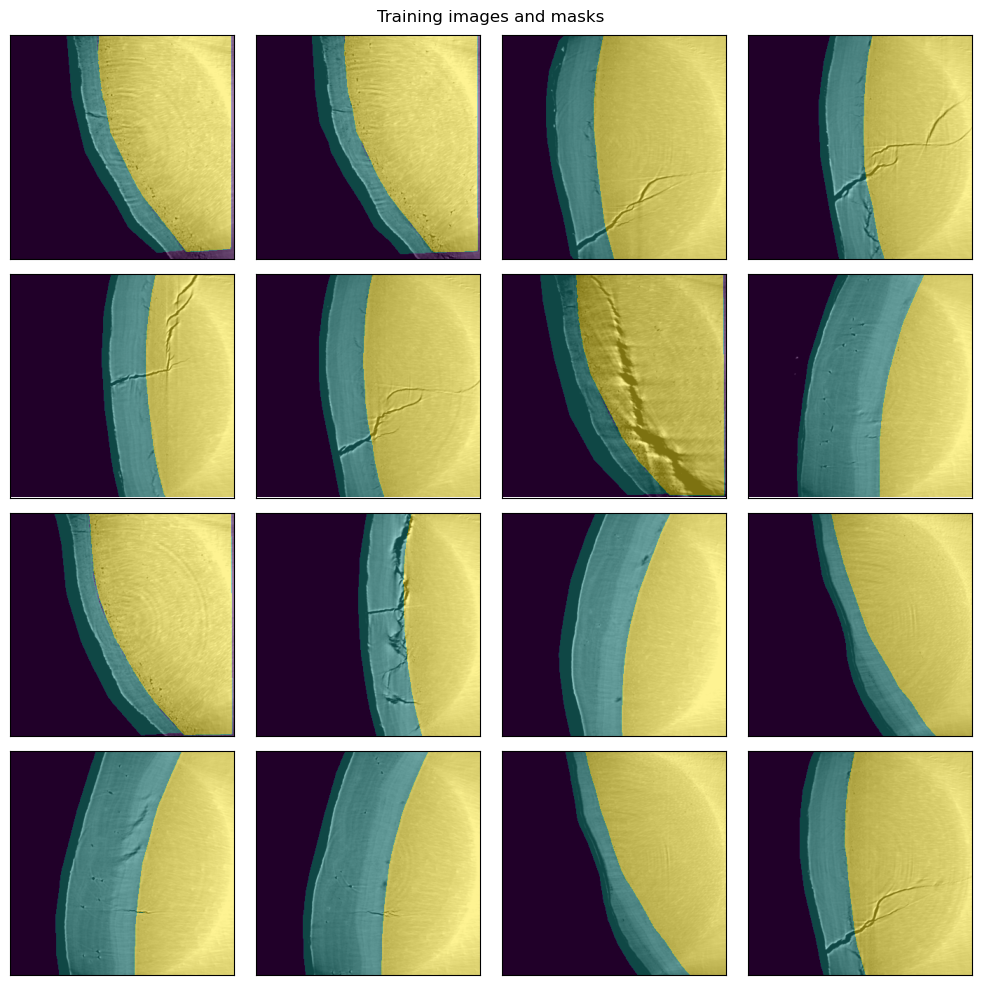

In [4]:
"""
Display some of them 

"""

rng = np.random.default_rng(seed=0)

indices = rng.choice(len(train_images), size=16, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in zip(indices, axes.flat):
    ax.imshow(train_images[i], cmap="gray")
    ax.imshow(train_masks[i], cmap="viridis", alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("Training images and masks")

fig.tight_layout()

fig.savefig(f"{img_dir}training_images_and_masks.png")

In [5]:
"""
Find class weights

"""

from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(train_masks)
class_weights = compute_class_weight(
    class_weight="balanced", classes=classes, y=train_masks.ravel()
)

# Increase cementum weight
class_weights[1] *= 8

class_weights = dict(enumerate(class_weights, start=0))

class_weights

{0: 0.9136543692956969, 1: 13.338325467718176, 2: 0.7658617029719764}

In [6]:
"""
Convert to arrays for training

"""
X_train = processing.imgs2array(train_images)
y_train = processing.masks2matrix(train_masks, len(classes))

X_train.shape, y_train.shape

((412, 320, 320, 1), (412, 320, 320, 3))

In [7]:
"""
Train uNet on these images; recording the loss

"""

from keras.optimizers import Adam
from keras.metrics import Precision, Recall
from cementum import unet


def new_model(*, dropout: float, learning_rate: float):
    model = unet.my_unet(
        n_classes=3,
        IMG_HEIGHT=train_images[0].shape[0],
        IMG_WIDTH=train_images[0].shape[1],
        IMG_CHANNELS=1,
        dropout=dropout,
    )

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy", Precision(), Recall()],
    )

    return model


model_params = {"dropout": 0.0, "learning_rate": 0.0002}
model = new_model(**model_params)

2024-03-04 11:32:41.541109: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-04 11:32:41.541296: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-04 11:32:41.541410: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
train_kw = {
    "class_weight": class_weights,
    "batch_size": 16,
    "epochs": 60,
    "validation_split": 0.2,
    "verbose": 1,
}

In [9]:
history = model.fit(X_train, y_train, **train_kw)

Epoch 1/60


2024-03-04 11:32:44.097100: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
2024-03-04 11:32:45.799427: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f83e19b2140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-04 11:32:45.799444: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-04 11:32:45.802408: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709551965.861394 1807911 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 [==============================] - 18s 352ms/step - loss: 2.1983 - accuracy: 0.1966 - precision: 0.2662 - recall: 0.1567 - val_loss: 1.4775 - val_accuracy: 0.2076 - val_precision: 0.2900 - val_recall: 0.2049
Epoch 2/60
21/21 [==============================] - 2s 87ms/step - loss: 1.2303 - accuracy: 0.3572 - precision: 0.5212 - recall: 0.3549 - val_loss: 1.1683 - val_accuracy: 0.3372 - val_precision: 0.4931 - val_recall: 0.3363
Epoch 3/60
21/21 [==============================] - 2s 87ms/step - loss: 0.8956 - accuracy: 0.5175 - precision: 0.7379 - recall: 0.4895 - val_loss: 0.7311 - val_accuracy: 0.6730 - val_precision: 0.7984 - val_recall: 0.5309
Epoch 4/60
21/21 [==============================] - 2s 86ms/step - loss: 0.6716 - accuracy: 0.8197 - precision: 0.8591 - recall: 0.5662 - val_loss: 0.5343 - val_accuracy: 0.9041 - val_precision: 0.8980 - val_recall: 0.5991
Epoch 5/60
21/21 [==============================] - 2s 85ms/step - loss: 0.5403 - accuracy: 0.9088 - precision: 0.890

In [10]:
def plot_model(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    epochs = range(1, len(loss) + 1)

    axes[0].plot(epochs, loss, "y", label="Training")
    axes[0].plot(epochs, val_loss, "r", label="Validation")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")

    axes[1].plot(epochs, acc, "y", label="Training")
    axes[1].plot(epochs, val_acc, "r", label="Validation")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[0].legend()

    axes[0].set_ylim(0.0, 3.0)
    axes[1].set_ylim(0.0, 1.0)

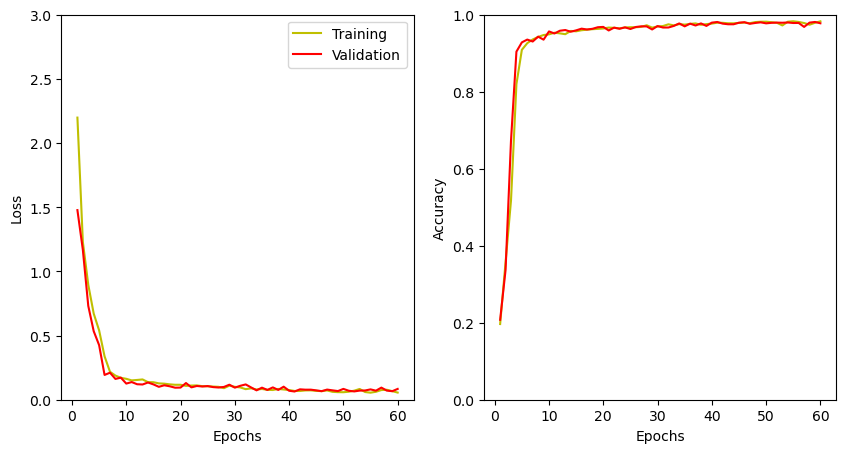

In [11]:
plot_model(history)
plt.savefig(f"{img_dir}training_loss.png")

In [12]:
"""
Apply to the test data + display

"""


def plot_predictions(model, images):
    assert len(images) == 16
    X_test = processing.imgs2array(images)

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for image, array, axis in zip(images, X_test, axes.flat):
        # Add a batch axis so the model can interpret the image
        # Find the class with the highest probability
        prediction = np.argmax(
            model.predict(array[np.newaxis, ...], verbose=0), axis=-1
        ).squeeze()

        axis.imshow(image)
        axis.imshow(prediction, alpha=0.5)

        axis.set_xticks([])
        axis.set_yticks([])

    fig.tight_layout()

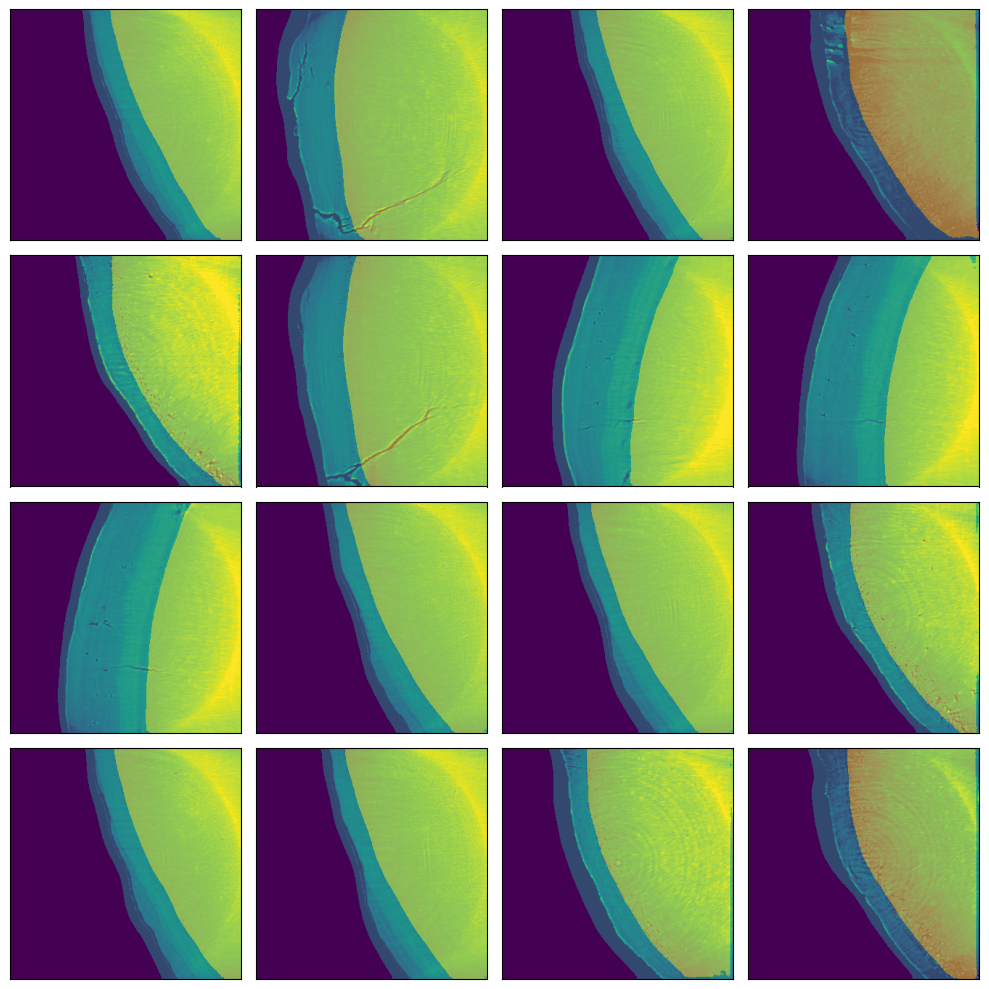

In [13]:
test_indices = rng.choice(len(test_images), size=16, replace=False)

plot_predictions(model, test_images[test_indices])
plt.savefig(f"{img_dir}test_predictions.png")

In [14]:
"""
Now let's try flipping and rotating the images randomly to see how that affects the training

"""

# Crop and flip the images
flipped_train_images, flipped_train_masks = processing.rotate_and_flip(gen, train_images, train_masks)

# Convert them to arrays
X_train_flipped = processing.imgs2array(flipped_train_images)
y_train_flipped = processing.masks2matrix(flipped_train_masks, len(classes))

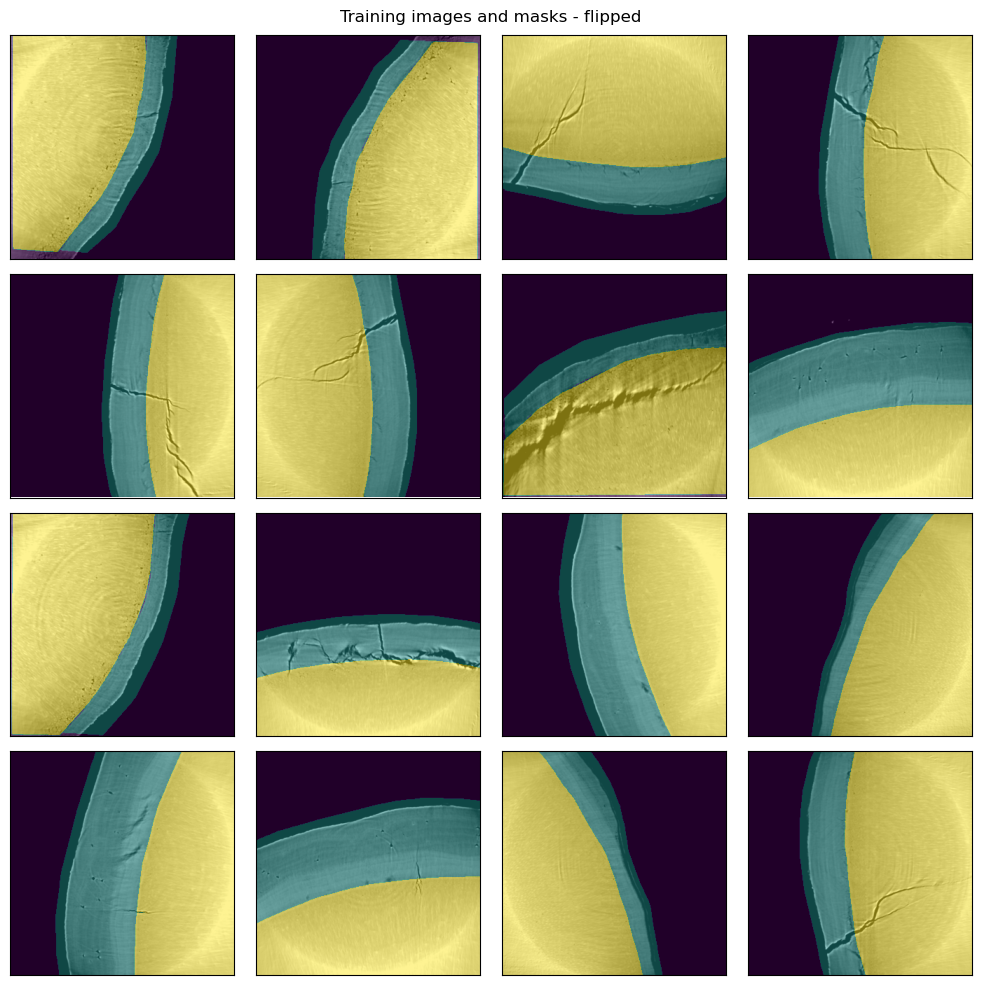

In [15]:
"""
Display some of them 

"""

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in zip(indices, axes.flat):
    ax.imshow(flipped_train_images[i], cmap="gray")
    ax.imshow(flipped_train_masks[i], cmap="viridis", alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("Training images and masks - flipped")

fig.tight_layout()
fig.savefig(f"{img_dir}flipped_training_images_and_masks.png")

In [16]:
flipped_model = new_model(**model_params)
flipped_history = flipped_model.fit(X_train_flipped, y_train_flipped, **train_kw)

Epoch 1/60
21/21 [==============================] - 5s 101ms/step - loss: 3.0745 - accuracy: 0.2531 - precision_1: 0.2803 - recall_1: 0.0965 - val_loss: 1.3588 - val_accuracy: 0.2101 - val_precision_1: 0.2813 - val_recall_1: 0.2021
Epoch 2/60
21/21 [==============================] - 2s 87ms/step - loss: 1.5959 - accuracy: 0.1994 - precision_1: 0.2687 - recall_1: 0.1956 - val_loss: 1.3041 - val_accuracy: 0.2077 - val_precision_1: 0.2862 - val_recall_1: 0.2046
Epoch 3/60
21/21 [==============================] - 2s 85ms/step - loss: 1.4304 - accuracy: 0.1990 - precision_1: 0.2833 - recall_1: 0.1959 - val_loss: 1.5095 - val_accuracy: 0.2074 - val_precision_1: 0.2890 - val_recall_1: 0.2062
Epoch 4/60
21/21 [==============================] - 2s 85ms/step - loss: 1.2835 - accuracy: 0.2184 - precision_1: 0.3154 - recall_1: 0.2047 - val_loss: 1.1465 - val_accuracy: 0.2189 - val_precision_1: 0.3178 - val_recall_1: 0.2132
Epoch 5/60
21/21 [==============================] - 2s 87ms/step - loss: 1.

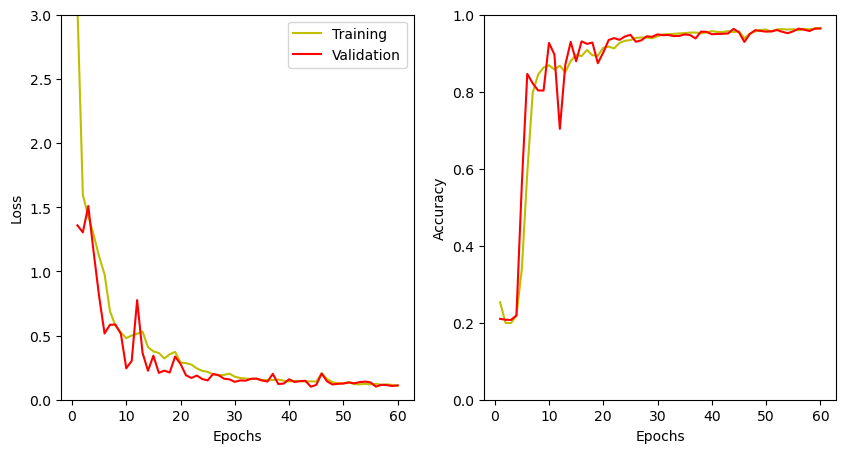

In [17]:
plot_model(flipped_history)
plt.savefig(f"{img_dir}flipped_training_loss.png")

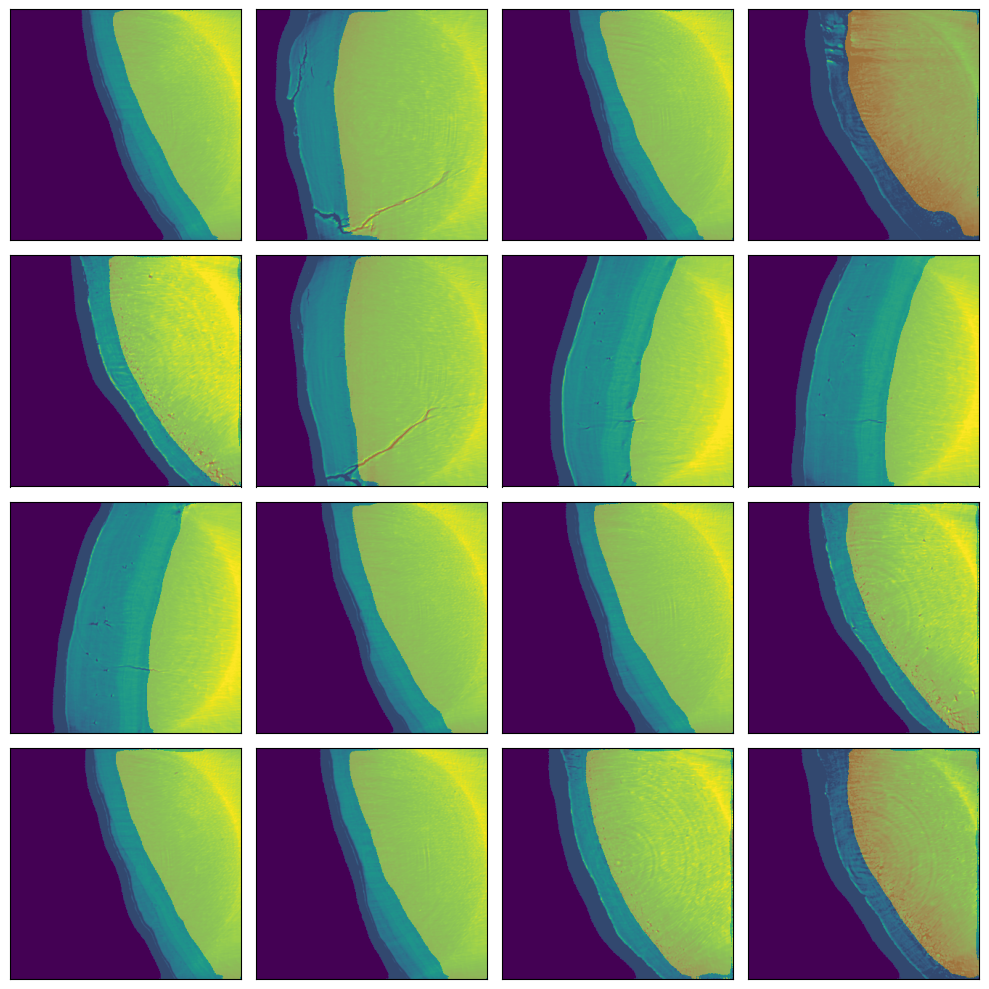

In [18]:
plot_predictions(flipped_model, test_images[test_indices])
plt.savefig(f"{img_dir}flipped_test_predictions.png")

In [23]:
"""
Let's ignore the flipped images for now and train the model on the original images - since it's clearly better

Let's try changing the learning rate to see what values we get

"""
from tqdm import tqdm

learning_rates = [0.02, 0.002, 0.0002, 0.00002, 0.000002, 0.0000002]
models = {}
histories = {}

train_kw["verbose"] = 0
for learning_rate in tqdm(learning_rates):
    _model = new_model(dropout=0.0, learning_rate=learning_rate)
    _history = _model.fit(X_train, y_train, **train_kw)
    # plot_model(_history)
    # plt.savefig(f"{img_dir}training_loss_{learning_rate=}.png")

    # plot_predictions(_model, test_images[test_indices])
    # plt.savefig(f"{img_dir}test_predictions_{learning_rate=}.png")

    models[learning_rate] = _model
    histories[learning_rate] = _history

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [11:08<00:00, 111.44s/it]


In [20]:
import pickle
with open(f"models.pkl", "wb") as f:
    pickle.dump(models, f)

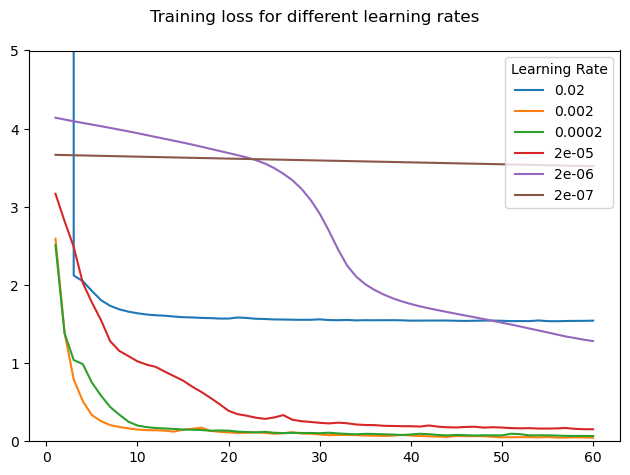

In [33]:
fig, axis = plt.subplots(1, 1)

for learning_rate, history in histories.items():
    axis.plot(
        range(1, len(models[learning_rate].history.history["loss"]) + 1),
        history.history["loss"],
        label=learning_rate,
    )

axis.legend(title="Learning Rate")
axis.set_ylim(0, 5)

fig.suptitle("Training loss for different learning rates")

fig.tight_layout()
fig.savefig(f"{img_dir}learning_rate_comparison.png")

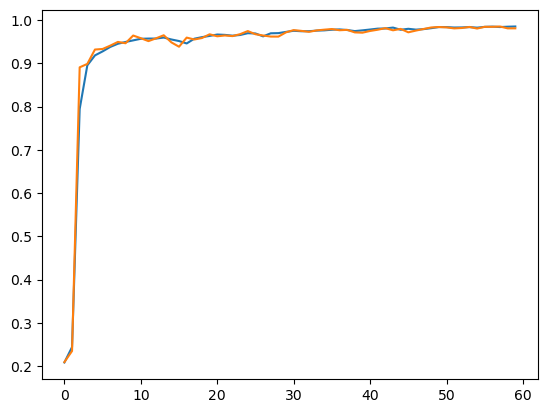

In [35]:
"""
Let's also plot the accuracy

"""

# The best learning rate
learning_rate = 0.002

fig, axis = plt.subplots(1, 1)

axis.plot(histories[learning_rate].history["accuracy"], label="Training")
axis.plot(histories[learning_rate].history["val_accuracy"], label="Validation")